# JOSE RODRIGUEZ
## Assessment for the People Data Analyst role at Canonical

# Problem Statement

A large Telecommunications company employs around 4000 employees. Every year, around 15% of their employees leave and need to be replaced. The management believes this attrition level to be a problem for the following reasons: 

- Project delays leading to a reputation loss amongst consumers and partners
- Big amount of resources is needed to maintain a large recruitment department 
- Work Productivity/Effectiveness is reduced due to the onboarding period for new staff

Hence, they contracted a workplace engineering & analytics firm to understand what factors are contributing to the high attrition, and what changes they should make to their workplace to support better retention. In addition, given limited resources, the company would like to know, which variable is the most important and needs to be addressed straight away.

Since you are the super star data scientist on the workplace engineering team, you’ve been tasked with the project. 

## Goal

- You are required to model the probability of attrition
- You will present the outcome and your recommendations to the (hypothetical) senior management team to help them understand what changes they should make to their workplace, in order to reduce the current attrition rate.
- As a data strategist, are there any recommendations you would make to improve the efficiency of our data collection/analysis process?

# Solution

Even though 5 different files were shared, I will leave aside the time-related files and focus on the general metrics file and the two survey files.

In [1]:
#import libraries
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine learning algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#Import metric for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import learning_curve, cross_val_score


## Data Preparation

In [2]:
# Load data files
general_data = pd.read_csv('https://github.com/canonical/workplace-engineering-take-home-test/blob/main/src/general_data.csv?raw=true')
manager_survey = pd.read_csv('https://github.com/canonical/workplace-engineering-take-home-test/blob/main/src/manager_survey_data.csv?raw=true')
employee_survey = pd.read_csv('https://github.com/canonical/workplace-engineering-take-home-test/blob/main/src/employee_survey_data.csv?raw=true')

In [3]:
#Preview data to ensure it has been loaded correctly
print(f"General Data: {general_data.shape}")
general_data.head(n=5)

General Data: (4410, 24)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


- **Problem**: predict probability of attrition
- **Target**: Attrition
- **Type**: it is a binary (Yes or No) classification problem

In [4]:
print(f"Manager Survey Data: {manager_survey.shape}")
manager_survey.head(n=5)

Manager Survey Data: (4410, 3)


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [5]:
print(f"Employee Survey Data: {employee_survey.shape}")
employee_survey.head(n=5)

Employee Survey Data: (4410, 4)


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


Since we have a unique identifier which is the 'EmployeeID', we can merge the 3 files to facilitate the analysis of the data by having a single data frame with all the variables together.

All files contain the same number of employees/rows (4410), but not all contain the same number of columns, the detail is as follows:
- General Data has 24 columns/variables.
- Manager Survey Data has 3 columns/variables.
- Employee Survey Data has 4 columns/variables.

In [6]:
# Merge General Data and Manager Survey Data
merged_data = pd.merge(general_data, manager_survey, on='EmployeeID', how='left')

# Merge the result with Employee Survey Data
general_and_survey_data = pd.merge(merged_data, employee_survey, on='EmployeeID', how='left')

# Print the shape of the final merged dataset
print(f"Final merged dataset shape: {general_and_survey_data.shape}")

Final merged dataset shape: (4410, 29)


In [7]:
# Check data info
general_and_survey_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Based on the output, here are the observations:

1. The merged dataset has 4410 rows, which matches the number of rows in each of the original files, indicating no rows were lost during the merge process.

2. There are now 29 columns in the merged dataset, combining all the columns from the three original files.

3. The column order is:
    - First the columns from the General Data file, where most columns are of numeric data types (int64 or float64), except for 'Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', and 'Over18' which are likely categorical variables with string/object data type.
    - Then the 'JobInvolvement' and 'PerformanceRating' columns from the Manager Survey Data file.
    - Finally, the satisfaction columns ('EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance') from the Employee Survey Data file.

4. The data types of the columns appear to be preserved correctly from the original files.

5. There are some missing values:
    - 'NumCompaniesWorked' has 19 missing values
    - 'TotalWorkingYears' has 9 missing values
    - 'EnvironmentSatisfaction' has 25 missing values
    - 'JobSatisfaction' has 20 missing values
    - 'WorkLifeBalance' has 38 missing values

The merge operation seems to have been successful, and now we have a consolidated dataset with all the relevant features from the three original files.

### Missing Values

In [8]:
# Count the number of rows with missing values
general_and_survey_data.isnull().any(axis=1).sum()

110

There are different ways to handle missing values, either by imputation using the mean, median or a more advanced technique such as the KNN imputer, or eliminating rows with missing values when the count is low and this will not significantly affect the size of the data set.

In this case, we have 110 rows with missing values, which represents about 2.5% (110/4410). Since this is such a low percentage, these rows will be removed.

In [9]:
# Drop rows with missing values in 'NumCompaniesWorked' and 'TotalWorkingYears'
general_and_survey_data = general_and_survey_data.dropna()

# Check the new shape of the data
print(f"New shape after removing missing values: {general_and_survey_data.shape}")

New shape after removing missing values: (4300, 29)


### Data Types

Observing the data types of the variables, there are some that, although they appear to be numerical, are actually ordinary variables, so they will be given the correct treatment.

In [10]:
# Create a dictionary to map the numeric values to labels
satisfaction = {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
rating = {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'}
balance = {1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'}
education = {1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'}

# Map the numeric values to labels for each variable
general_and_survey_data['EnvironmentSatisfaction'] = general_and_survey_data['EnvironmentSatisfaction'].replace(satisfaction)
general_and_survey_data['JobInvolvement'] = general_and_survey_data['JobInvolvement'].replace(satisfaction)
general_and_survey_data['JobSatisfaction'] = general_and_survey_data['JobSatisfaction'].replace(satisfaction)
general_and_survey_data['EnvironmentSatisfaction'] = general_and_survey_data['EnvironmentSatisfaction'].replace(satisfaction)
general_and_survey_data['PerformanceRating'] = general_and_survey_data['PerformanceRating'].replace(rating)
general_and_survey_data['WorkLifeBalance'] = general_and_survey_data['WorkLifeBalance'].replace(balance)
general_and_survey_data['Education'] = general_and_survey_data['Education'].replace(education)

In [11]:
#Review variables that appear to be numerical
general_and_survey_data.describe()

,Age,DistanceFromHome,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4300.000000,4300.000000,4300.0,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.0,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000
mean,36.926977,9.197907,1.0,2211.695116,2.066977,65059.844186,2.690000,15.210698,8.0,0.795349,11.285116,2.796279,7.026047,2.190000,4.132558
std,9.146517,8.097059,0.0,1272.117692,1.106633,47045.398914,2.495764,3.662777,0.0,0.853534,7.790052,1.290142,6.148036,3.230818,3.565831
min,18.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,1.0,1110.750000,1.000000,29260.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,7.000000,1.0,2215.500000,2.000000,49360.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,1.0,3314.250000,3.000000,83802.500000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.250000,3.000000,7.000000
max,60.000000,29.000000,1.0,4409.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


- There are two variables that have zero standard deviation, so they can be removed because it means that all employees have the same data ('EmployeeCount', StandardHours').
- Although some variables do not have established levels in the data dictionary, they are still ordinal variables, so they should be excluded from numerical variables ('JobLevel', 'StockOptionLevel').
- There is also the employee identifier, so that must be isolated from the analysis.

In [12]:
# Identify unnecessary columns
columns_to_remove = ['EmployeeCount', 'StandardHours']

# Remove the specified columns from the DataFrame
general_and_survey_data = general_and_survey_data.drop(columns=columns_to_remove)

In [13]:
# Convert numerical variable to categorical variable
general_and_survey_data['JobLevel'] = general_and_survey_data['JobLevel'].astype('category')
general_and_survey_data['StockOptionLevel'] = general_and_survey_data['StockOptionLevel'].astype('category')

In [14]:
# Classification of variables
target = general_and_survey_data['Attrition']
numeric_cols = general_and_survey_data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols[numeric_cols != 'EmployeeID']
categorical_cols = general_and_survey_data.select_dtypes(include=['category', 'object']).columns
categorical_cols = categorical_cols[categorical_cols != 'Attrition']

### Outliers

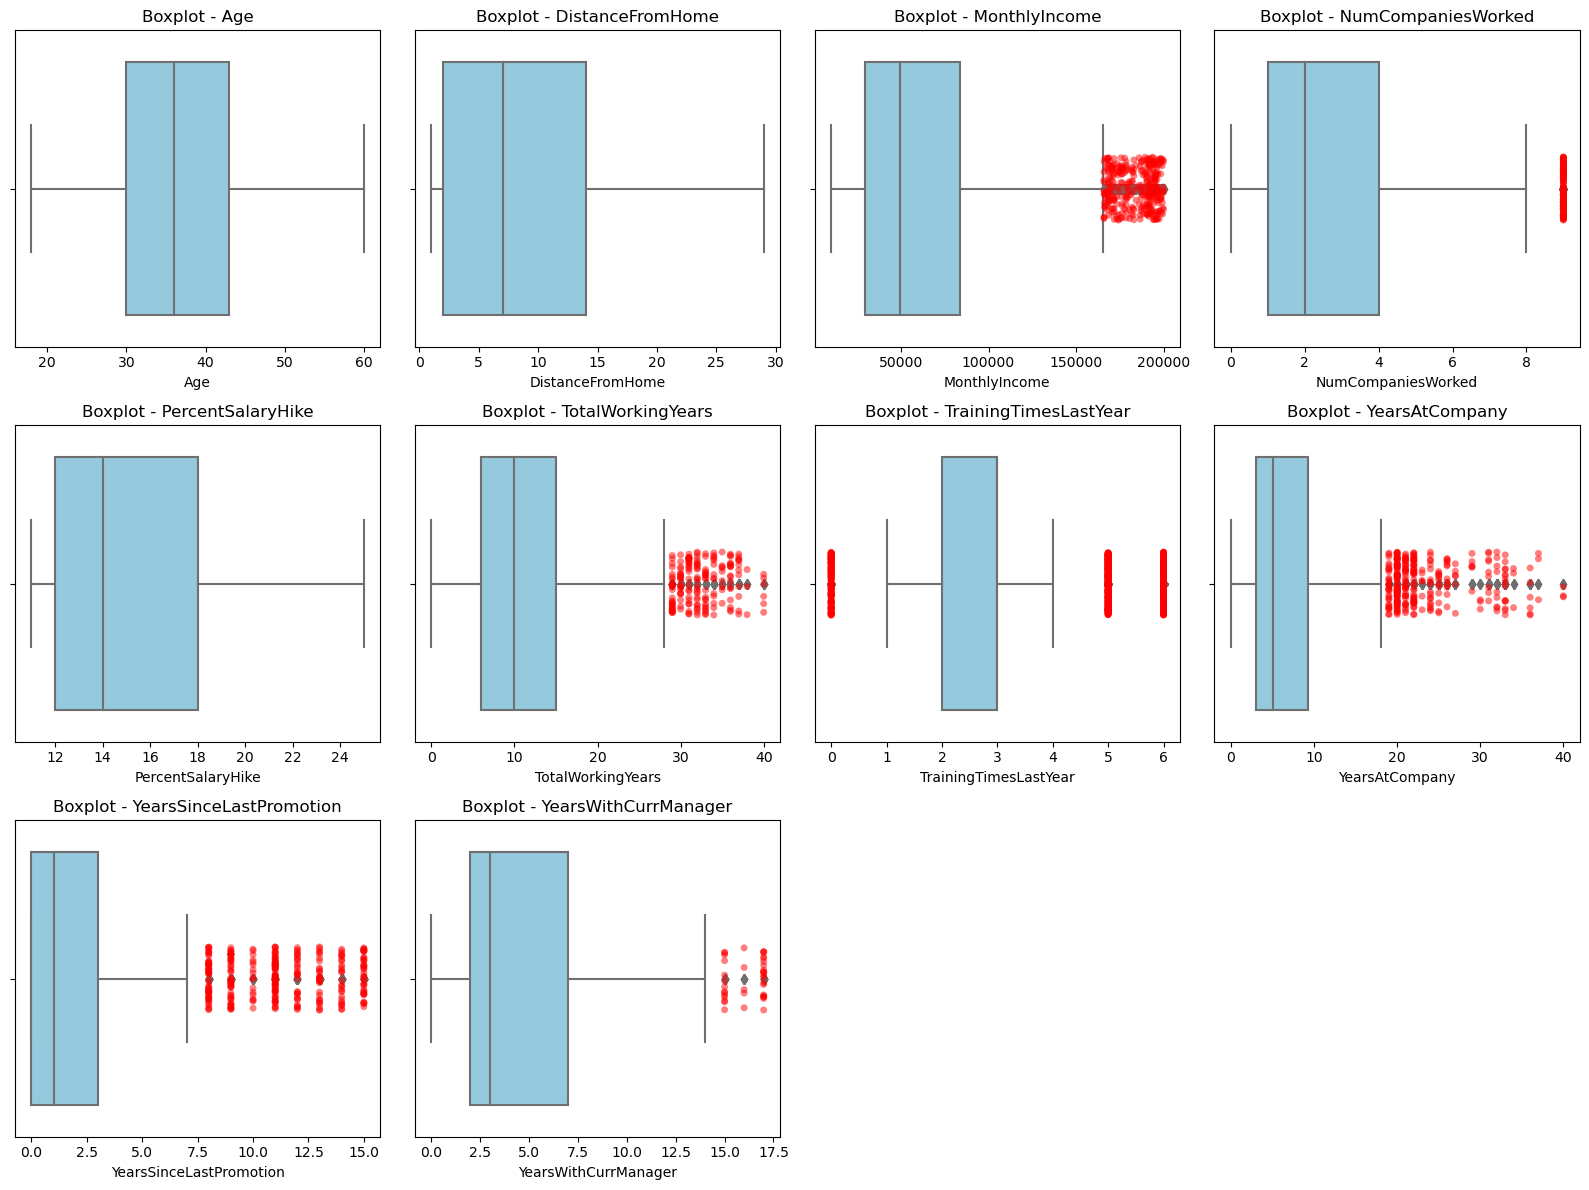

In [15]:
# Calculate the number of rows and columns required
num_plots = len(numeric_cols)
num_cols_per_row = 4
num_rows = (num_plots - 1) // num_cols_per_row + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(16, 4*num_rows))

# Plot each numerical column
for i, col in enumerate(numeric_cols):
    row_index = i // num_cols_per_row
    col_index = i % num_cols_per_row
    ax = axes[row_index, col_index]
    
    # Calculate quartiles and IQR
    q1 = general_and_survey_data[col].quantile(0.25)
    q3 = general_and_survey_data[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calculate the bounds for outliers
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Identify outliers
    outliers = general_and_survey_data[(general_and_survey_data[col] < lower_bound) | (general_and_survey_data[col] > upper_bound)]
    
    # Create box plot with outliers highlighted
    sns.boxplot(data=general_and_survey_data, x=col, ax=ax, color='skyblue')
    sns.stripplot(data=outliers, x=col, ax=ax, color='red', size=5, alpha=0.5)
    
    # Set title and labels
    ax.set_title(f"Boxplot - {col}")
    ax.set_xlabel(col)
    ax.set_ylabel('')
    
# Hide empty subplots if needed
if i < (num_rows * num_cols_per_row) - 1:
    for j in range(i + 1, num_rows * num_cols_per_row):
        row_index = j // num_cols_per_row
        col_index = j % num_cols_per_row
        fig.delaxes(axes[row_index, col_index])
    
# Adjust layout
plt.tight_layout()
plt.show()


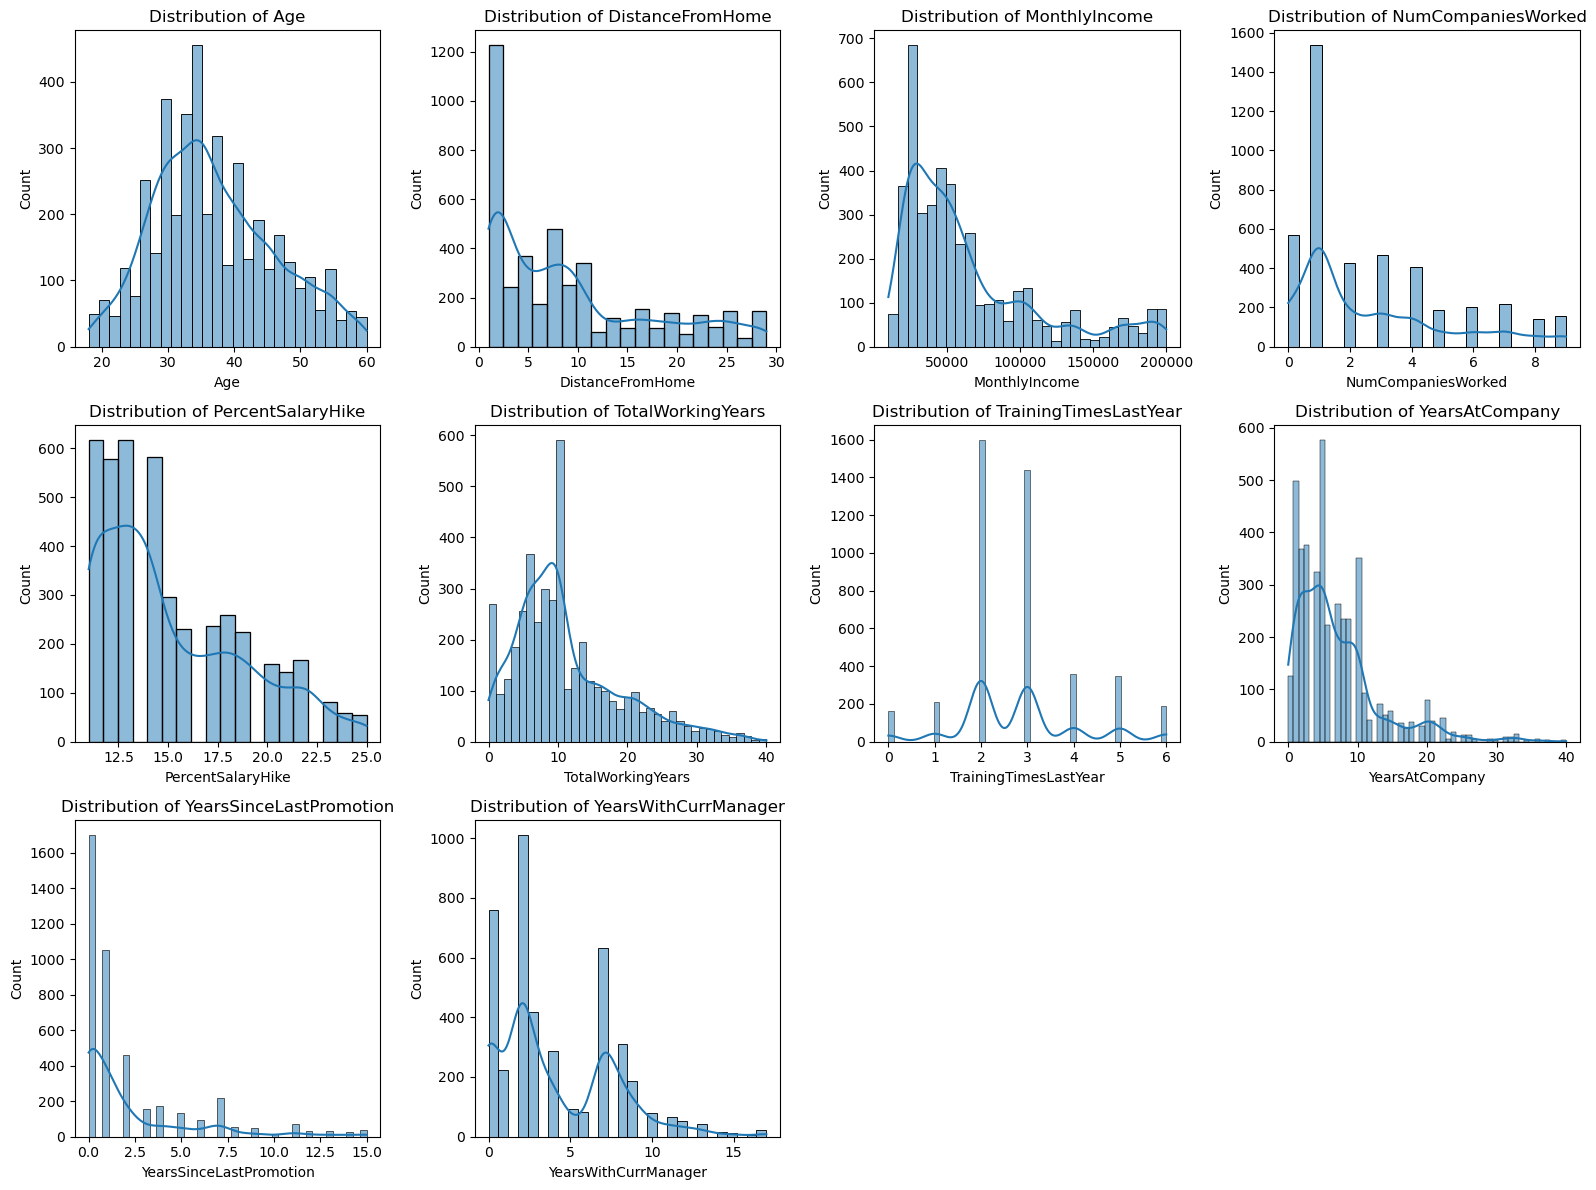

In [16]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(16, 4*num_rows))

# Plot each numerical column
for i, col in enumerate(numeric_cols):
    row_index = i // num_cols_per_row
    col_index = i % num_cols_per_row
    ax = axes[row_index, col_index]
    sns.histplot(data=general_and_survey_data, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

# Hide empty subplots if needed
if i < (num_rows * num_cols_per_row) - 1:
    for j in range(i + 1, num_rows * num_cols_per_row):
        row_index = j // num_cols_per_row
        col_index = j % num_cols_per_row
        fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

Analyzing results:
- 7 of the 10 numerical variables have extreme values, however, when also analyzing the distribution of the data, the values make sense and may be possible, so it is better to keep them.
- Most of the columns are in the form of a skewed distribution, except for 'Age' and 'TrainingTimesLastYear'
- 'Age' and 'TrainingTimesLastYear' seem to have a normal distribution

## EDA

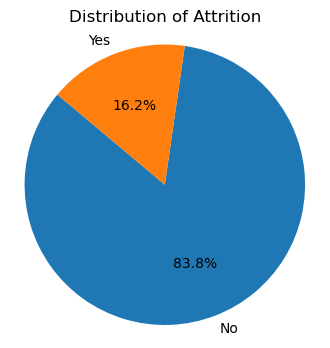

In [17]:
# Analyze distribution of the target: Attrition

# Calculate value counts of the target column
target_counts = target.value_counts()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Attrition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


As seen in the pie chart, approximately 16% of employees left the company in the last year vs. 84% who stayed there.

Although there is no strict cutoff percentage that definitively determines whether the data is unbalanced or not, we can consider the data to be slightly unbalanced since the percentage of the minority class ("Yes" for attrition) is less than 20%.

### Categorical Columns

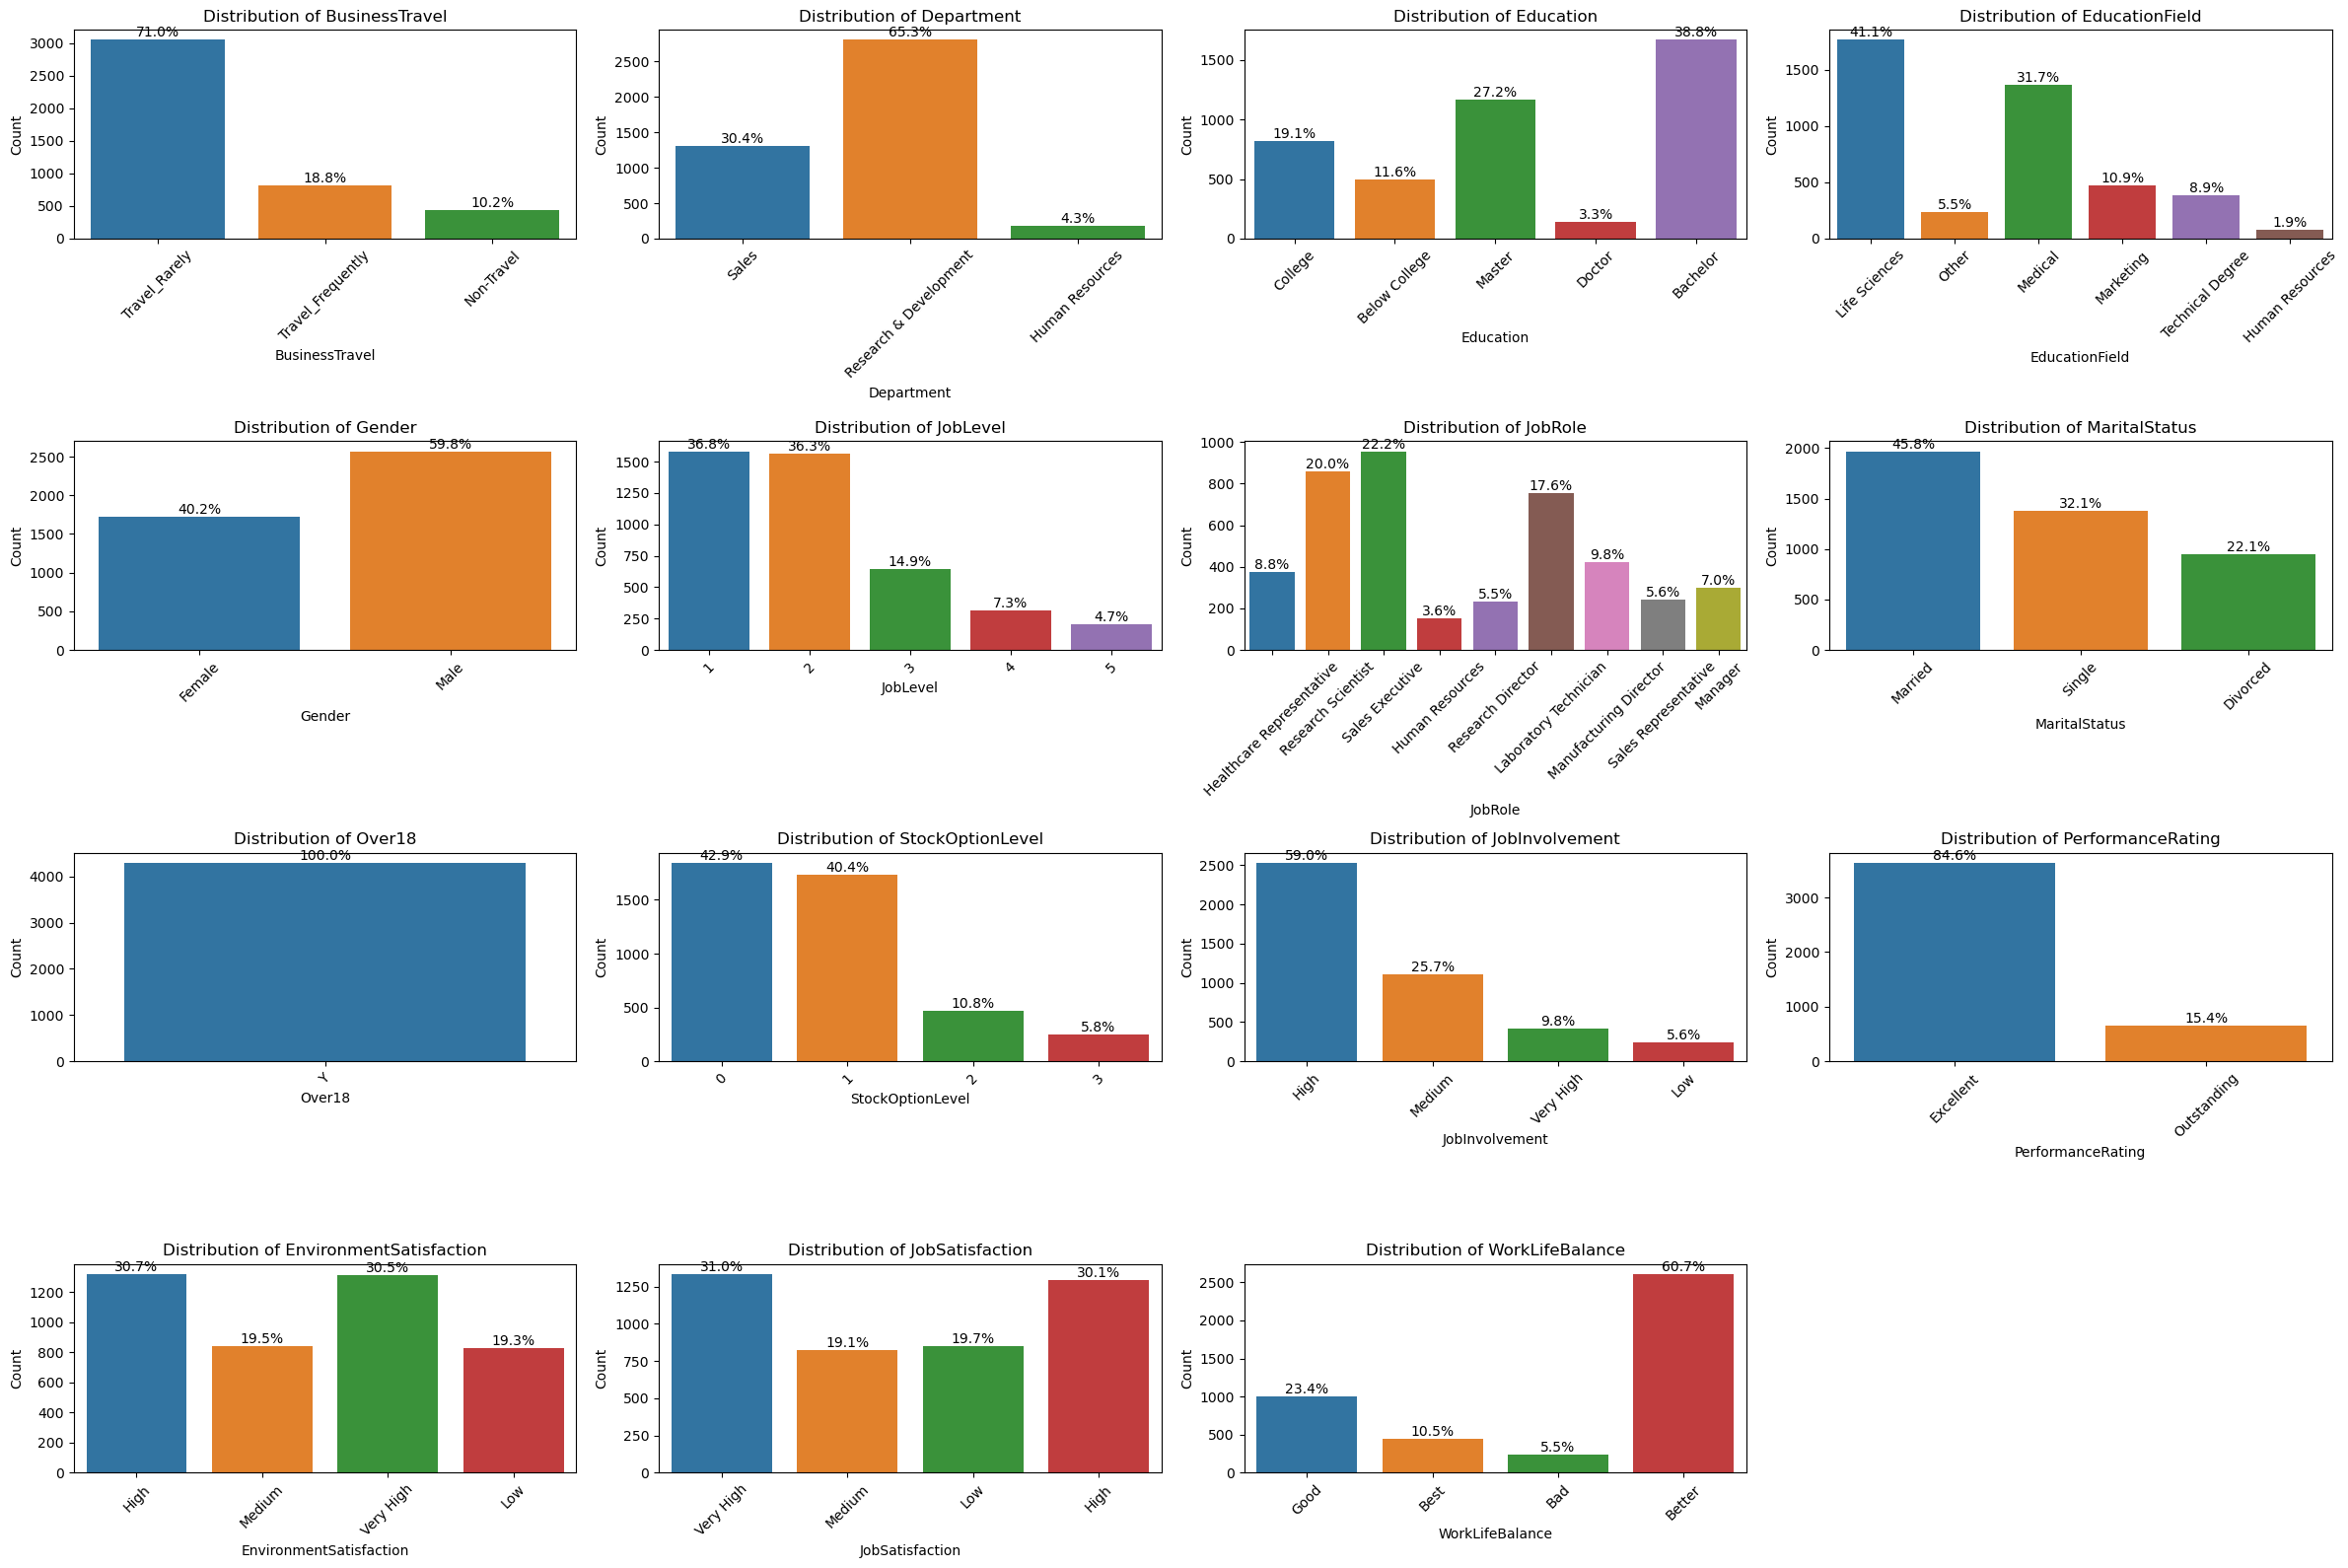

In [18]:
# Calculate the number of rows and columns required
num_plots = len(categorical_cols)
num_cols_per_row = 4  
num_rows = (num_plots - 1) // num_cols_per_row + 1

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(6*num_cols_per_row, 4*num_rows))

# Plot each categorical variable
for i, col in enumerate(categorical_cols):
    row_index = i // num_cols_per_row
    col_index = i % num_cols_per_row
    ax = axes[row_index, col_index]
    
    # Create count plot
    sns.countplot(data=general_and_survey_data, x=col, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    
    # Add percentage text annotations
    total_counts = general_and_survey_data[col].value_counts()
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y, f'{(y / total_counts.sum())*100:.1f}%', ha='center', va='bottom')

# Hide empty subplots
if num_plots < num_rows * num_cols_per_row:
    for j in range(num_plots, num_rows * num_cols_per_row):
        fig.delaxes(axes.flatten()[j])

# Adjust layout
plt.tight_layout()
plt.show()


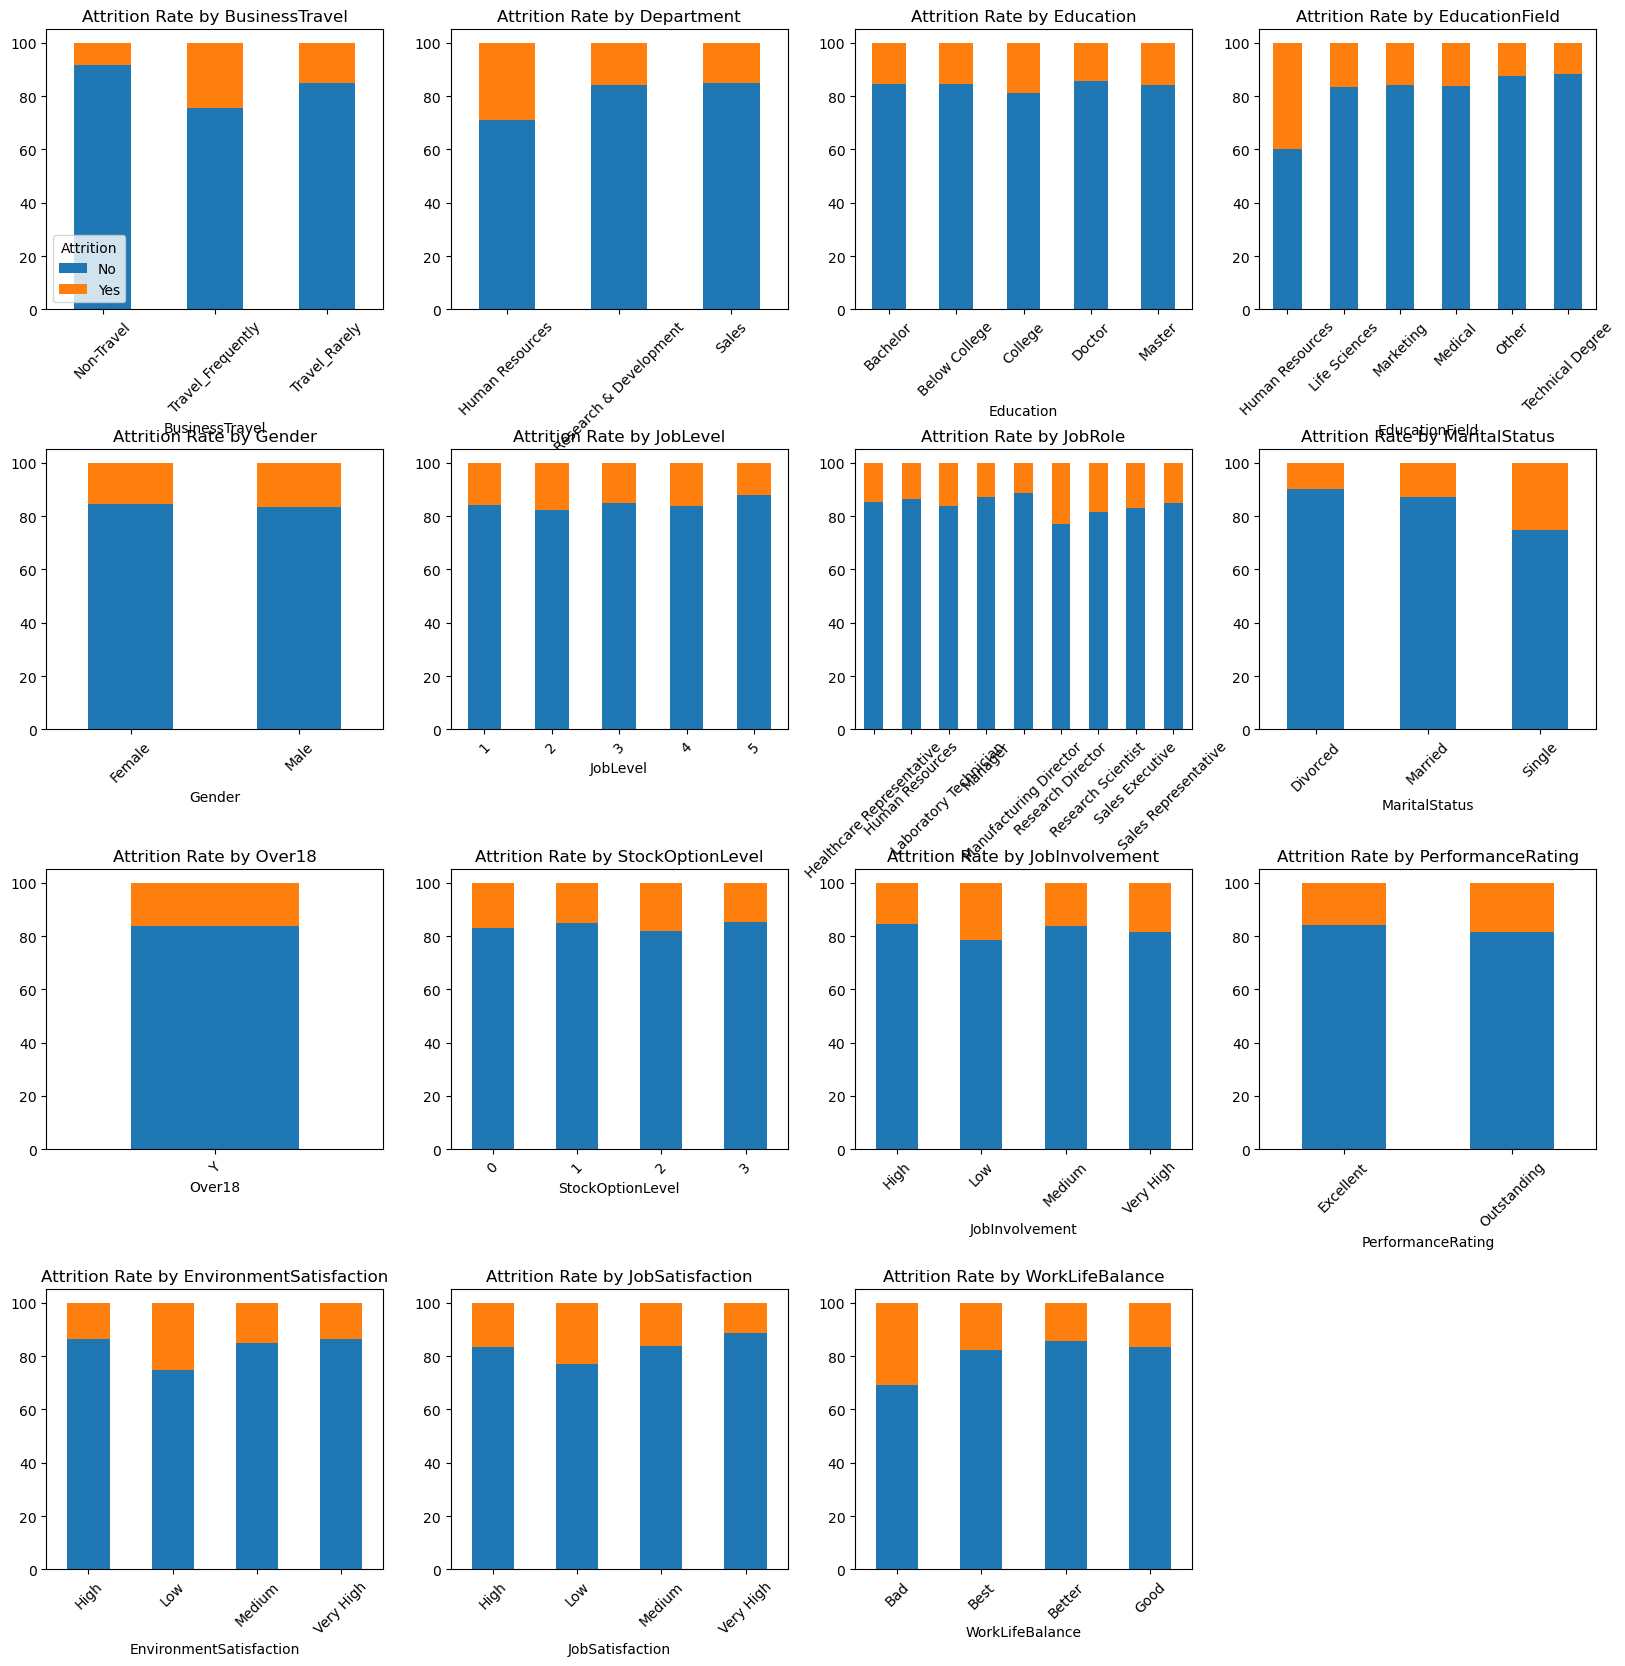

In [19]:
#Analysis by target

# Create a grid of subplots
num_cols = 4
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the categorical columns and plot
for i, col in enumerate(categorical_cols):
    # Create a crosstab of the categorical variable and the target
    crosstab = pd.crosstab(index=general_and_survey_data[col], columns=general_and_survey_data['Attrition'])
    
    # Calculate the percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    crosstab_percent.plot(kind='bar', stacked=True, ax=axs[i], legend=i==0)
    
    # Set the title and rotate x-axis labels
    axs[i].set_title(f'Attrition Rate by {col}')
    axs[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

In general terms, it seems that there are no categorical variables that clearly show what characteristics could influence attrition in the company.

Some of the variables that show slight signs are:
- Business Travel: those who travel frequently
- Department and EducationField: people from HR, however, In both variables, the percentage of people in that department or with those studies is very low.
- Marital Status: those who are single
- EnvironmentSatisfaction = Low
- WorkLifeBalance = Bad

It's also importan to mention that the column Over18 can be removed because everyone is over 18 years old.

In [20]:
# Remove OVER18 from the DataFrame
general_and_survey_data = general_and_survey_data.drop(columns='Over18')

### Numerical Columns

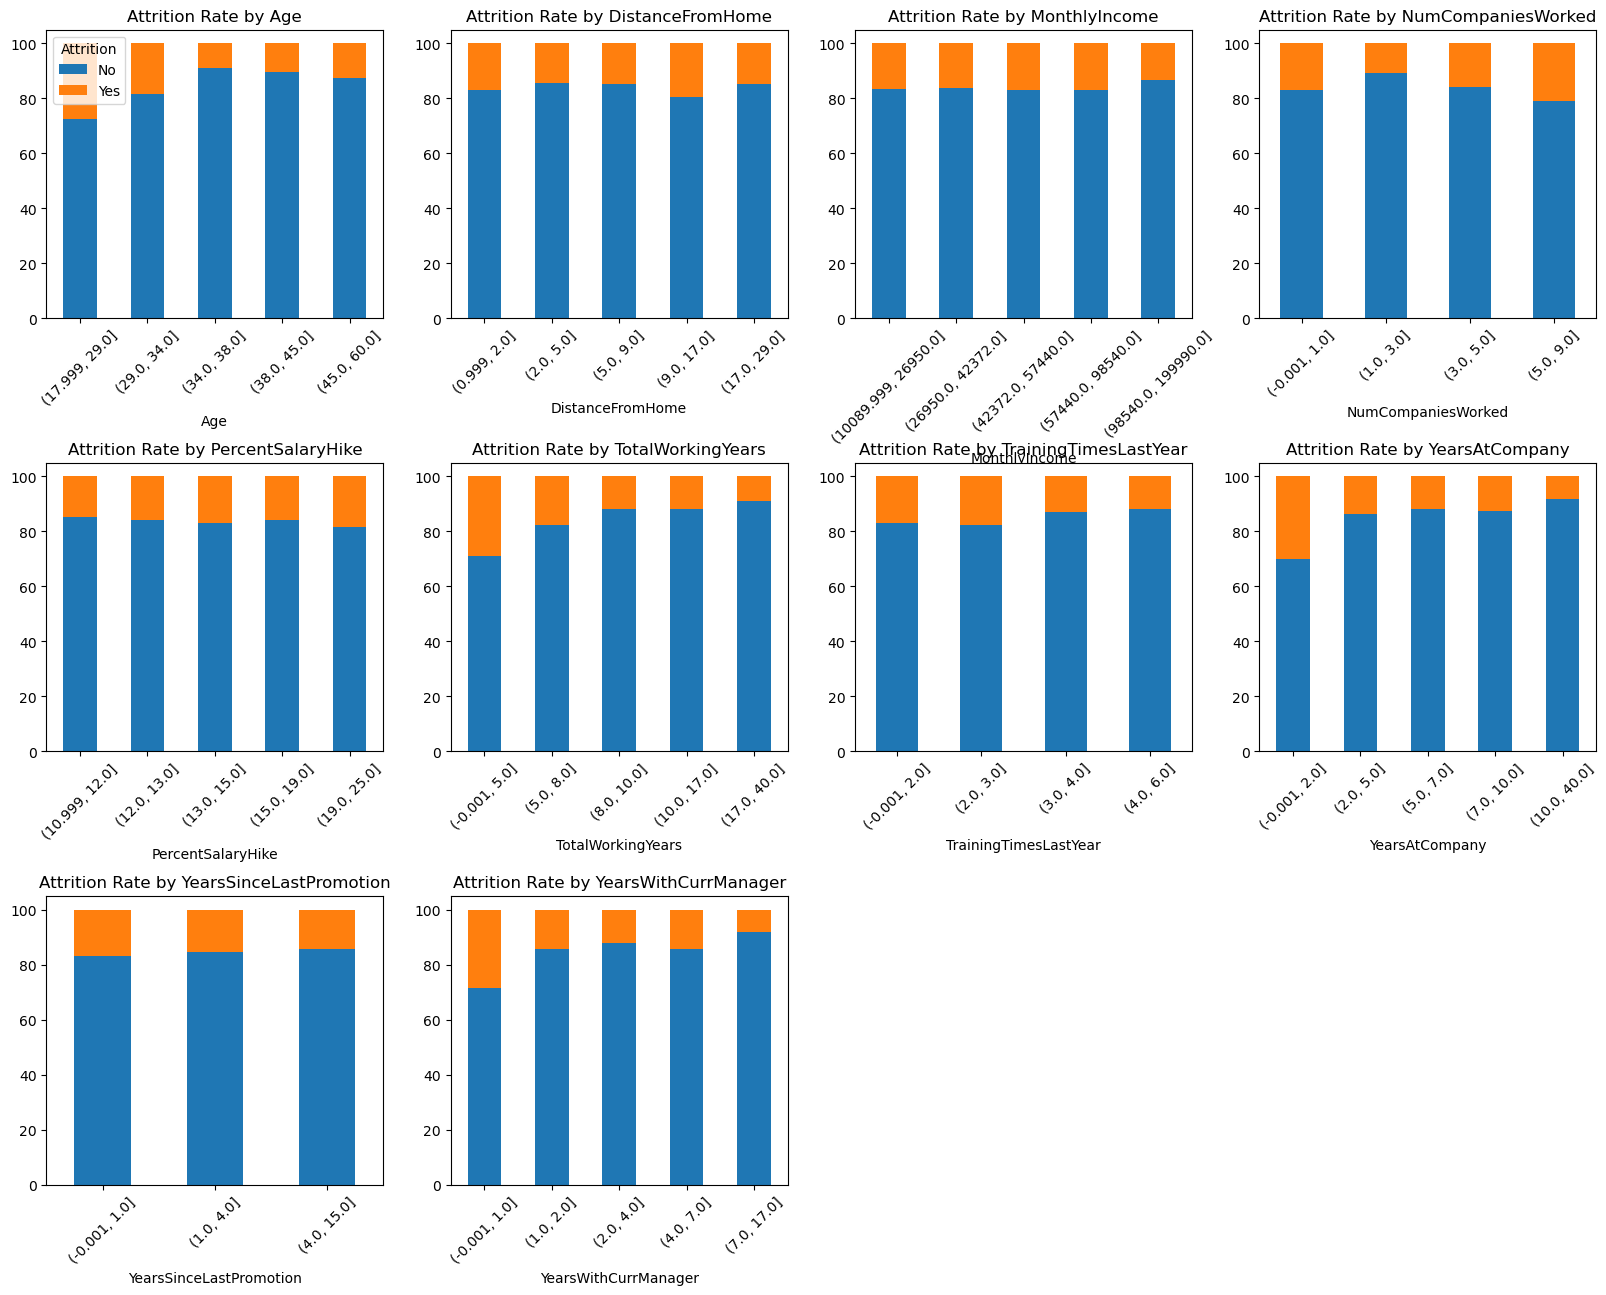

In [21]:
# Create a grid of subplots
num_cols = 4
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the numerical columns and plot
for i, col in enumerate(numeric_cols):
    # Bin the numerical variable
    bins = pd.qcut(general_and_survey_data[col], q=5, duplicates='drop')
    
    # Create a crosstab of the binned variable and the target
    crosstab = pd.crosstab(index=bins, columns=general_and_survey_data['Attrition'])
    
    # Calculate the percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    crosstab_percent.plot(kind='bar', stacked=True, ax=axs[i], legend=i==0)
    
    # Set the title and rotate x-axis labels
    axs[i].set_title(f'Attrition Rate by {col}')
    axs[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

The numerical variables seem to show certain characteristics why employees tend to leave the company, some of them are:
- Age: the youngest people (less than 34 years old) are the ones who tend to leave the company faster
- 'TotalWorkingYears', 'YearsAtCompany' and 'YearsWithCurrManager': the people with the least amount of time in these variables are the ones who tend to leave.

## Correlation

Checking for multicollinearity, or the presence of highly correlated predictors, is a good practice in any machine learning model. This is because highly correlated predictors can lead to unstable and non-unique estimates of the model coefficients, difficulty in model interpretability, and decreased prediction accuracy.

While some models are more sensitive to multicollinearity than others, it is still a good idea to check for it in all models. For example, linear models such as linear regression and logistic regression are particularly sensitive to multicollinearity, and it can have a significant impact on the model coefficients and predictions. On the other hand, tree-based models are generally less sensitive to multicollinearity but can still benefit from removing highly correlated predictors.

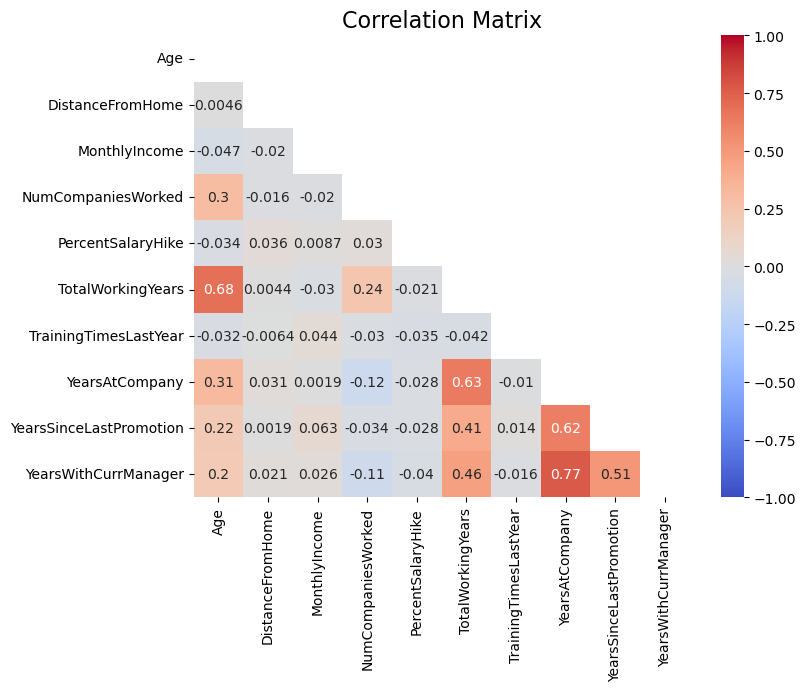

In [22]:
#Correlation for numeric columns
# Calculate the correlation matrix
corr_matrix = general_and_survey_data[numeric_cols].corr()

# Create a mask to remove the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

The correlation threshold for removing highly correlated features depends on several factors, such as the size of the data set, the type of features, and the objectives of the analysis. Although there is no universally accepted threshold, a common value used in practice is 0.75 or 0.80, but you can choose a higher or lower threshold depending on the characteristics of the data. For this exercise I will use 0.80.

Because there are no characteristics with a correlation greater than 80%, no variable will be eliminated at this point.

In [23]:
#Correlation for categorical columns
# Initialize a dictionary to store chi-square statistics and p-values
chi2_results = {}

#Remove Over18 from initial list
categorical_cols = categorical_cols[categorical_cols != 'Over18']

# Iterate through combinations of categorical variables
for var1, var2 in combinations(categorical_cols, 2):
    # Create a contingency table
    contingency_table = pd.crosstab(general_and_survey_data[var1], general_and_survey_data[var2])
    
    # Perform chi-square test
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    
    # Store results
    chi2_results[(var1, var2)] = {'chi2_stat': chi2_stat, 'p_val': p_val}

# Display results
for pair, result in chi2_results.items():
    var1, var2 = pair
    print(f"Chi-square test between {var1} and {var2}:")
    print(f"Chi-square statistic: {result['chi2_stat']}")
    print(f"p-value: {result['p_val']}")
    print()


Chi-square test between BusinessTravel and Department:
Chi-square statistic: 27.95054310440011
p-value: 1.2764134978586198e-05

Chi-square test between BusinessTravel and Education:
Chi-square statistic: 17.90279803199023
p-value: 0.02196714702109865

Chi-square test between BusinessTravel and EducationField:
Chi-square statistic: 52.98894703663097
p-value: 7.481225706204845e-08

Chi-square test between BusinessTravel and Gender:
Chi-square statistic: 6.474780866568968
p-value: 0.03926622936205744

Chi-square test between BusinessTravel and JobLevel:
Chi-square statistic: 37.637800984280254
p-value: 8.781281585132825e-06

Chi-square test between BusinessTravel and JobRole:
Chi-square statistic: 26.530533430223535
p-value: 0.04700544233455314

Chi-square test between BusinessTravel and MaritalStatus:
Chi-square statistic: 21.33556131000924
p-value: 0.00027166268171658595

Chi-square test between BusinessTravel and StockOptionLevel:
Chi-square statistic: 10.974293811829982
p-value: 0.089

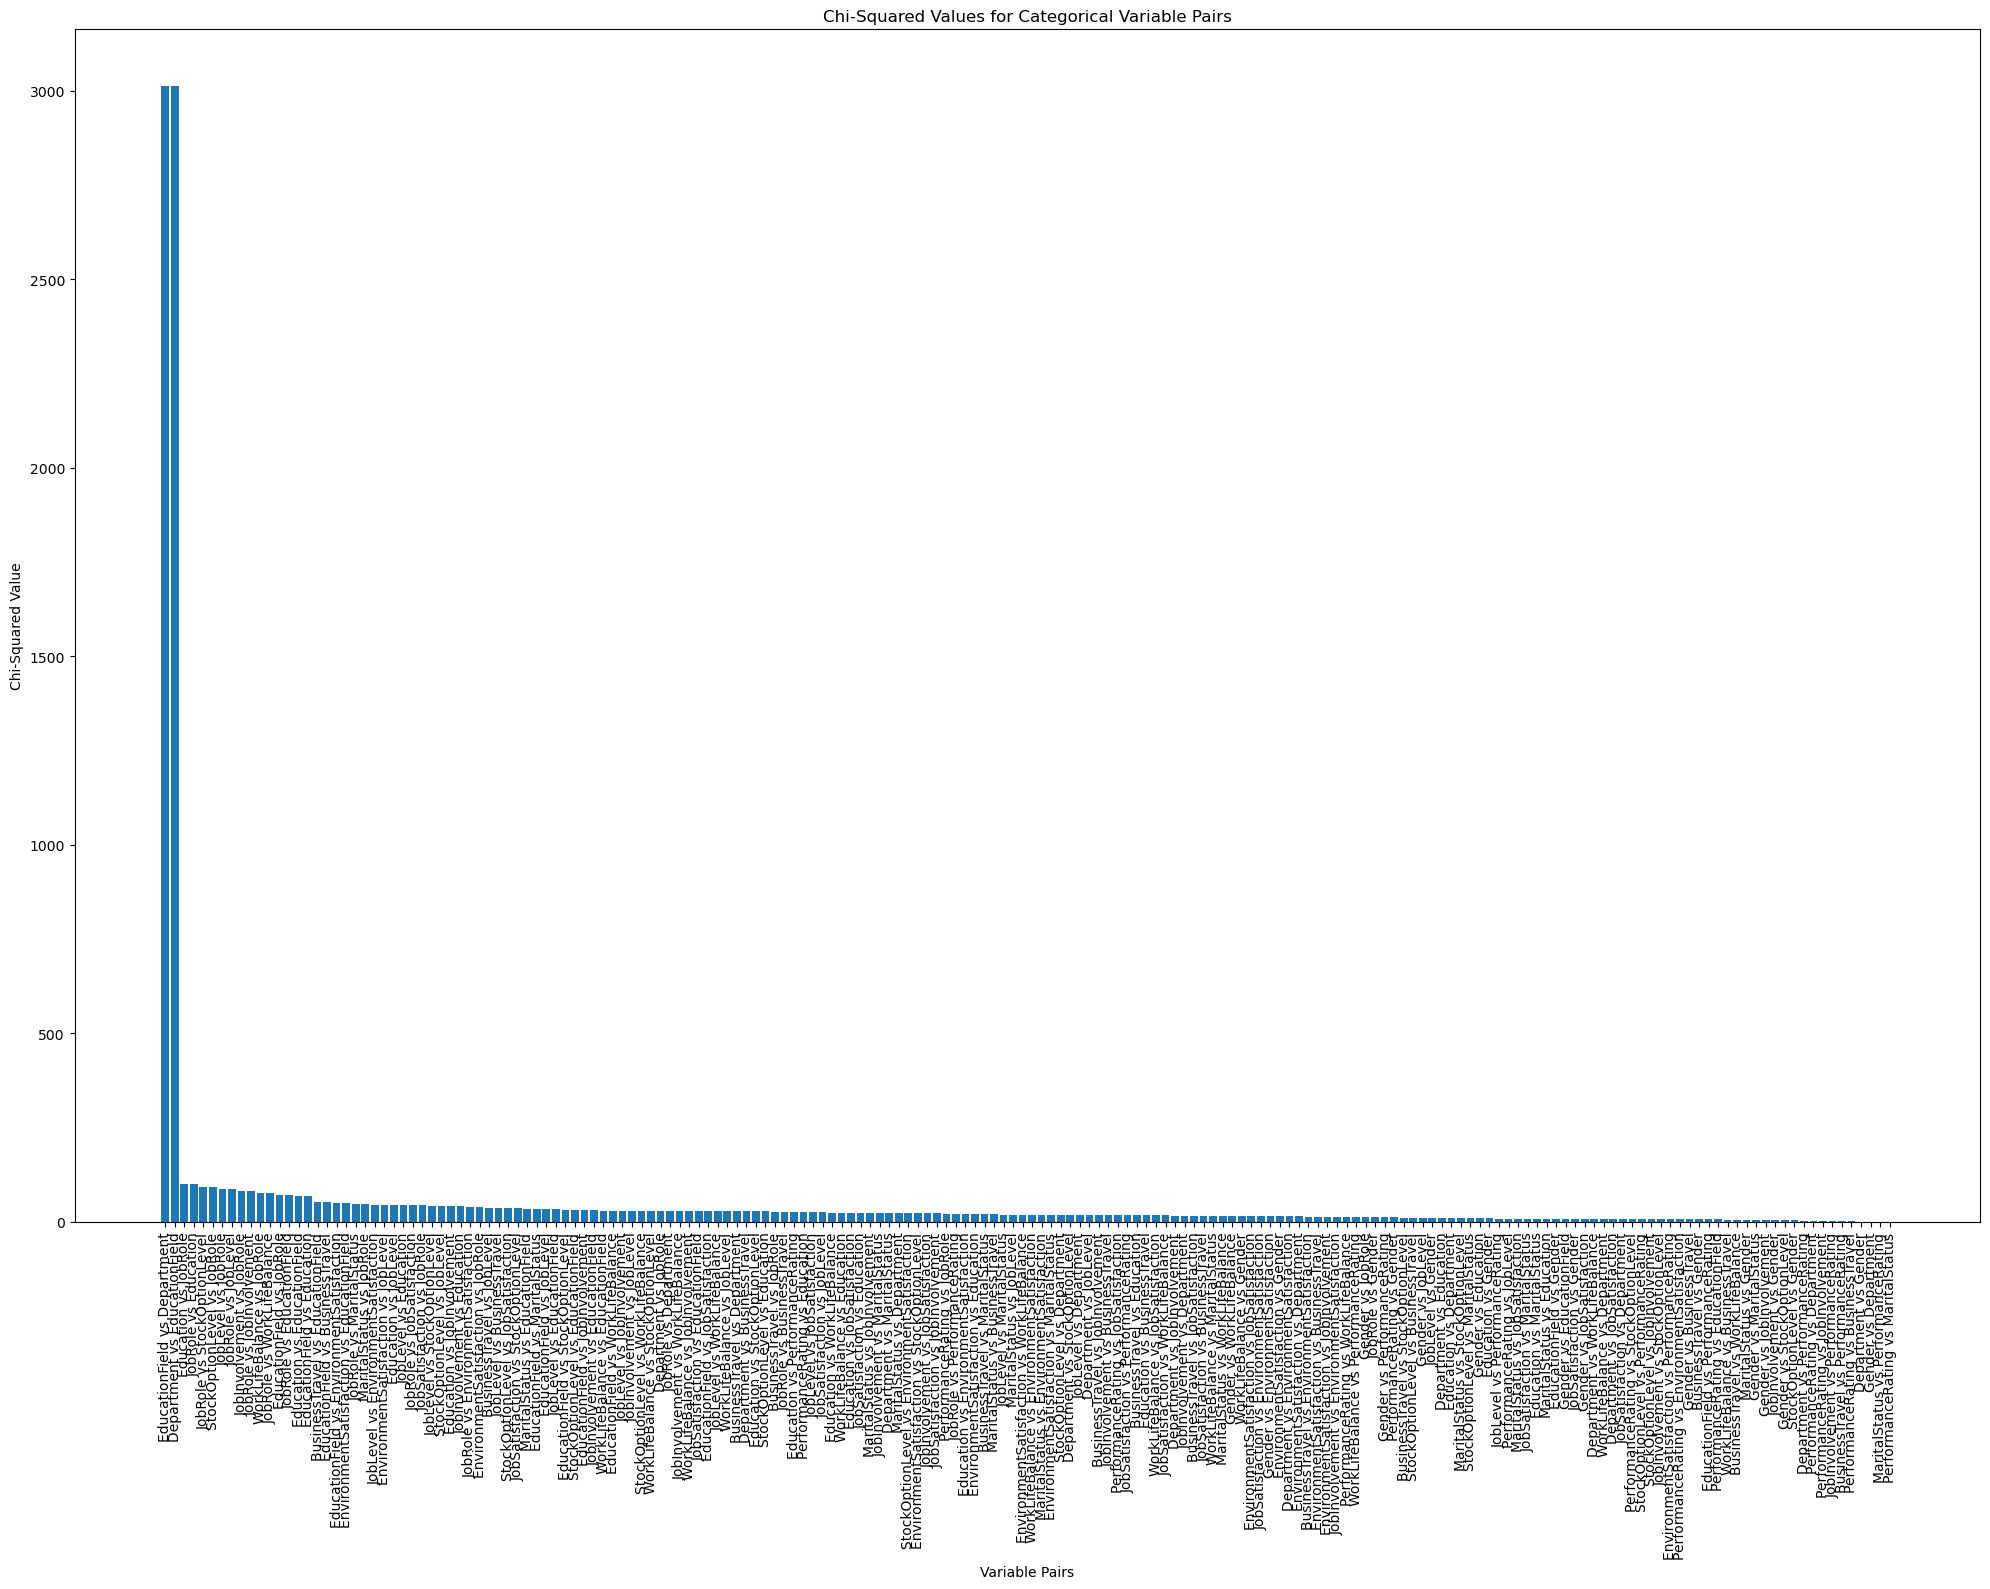

In [24]:
# Create a list to store chi-squared values and p-values
chi2_results = []

# Iterate over pairs of categorical columns
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            # Create a crosstab
            crosstab = pd.crosstab(general_and_survey_data[col1], general_and_survey_data[col2])
            
            # Calculate the chi-squared statistic and p-value
            chi2, p_val, dof, expected = chi2_contingency(crosstab)
            
            # Store the results
            chi2_results.append((col1, col2, chi2, p_val))

# Sort the results by chi-squared value in descending order
chi2_results.sort(key=lambda x: x[2], reverse=True)

# Plot the chi-squared values
fig, ax = plt.subplots(figsize=(20, 16))
x = range(len(chi2_results))
labels = [f"{col1} vs {col2}" for col1, col2, _, _ in chi2_results]
chi2_values = [chi2 for _, _, chi2, _ in chi2_results]
ax.bar(x, chi2_values)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_title("Chi-Squared Values for Categorical Variable Pairs")
ax.set_xlabel("Variable Pairs")
ax.set_ylabel("Chi-Squared Value")
plt.tight_layout()
plt.show()

Without a doubt, a great relationship is observed between the department and the field of education. There are other related variables, but this one stands out above all.

## Model Building

In [25]:
# Indetify dependant and independant variables
X = general_and_survey_data.drop(['Attrition'],axis=1)
y = general_and_survey_data['Attrition']
y = y.map({'Yes': 1, 'No': 0})

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)

# After splitting the data, we can remove the customerID again
train_EmpID = X_train['EmployeeID']
X_train = X_train.drop(columns = ['EmployeeID'])
test_EmpID = X_test['EmployeeID']
X_test = X_test.drop(columns = ['EmployeeID'])

### Feature Scaling

Feature scaling is not always necessary/required for some machine learning models, however, this database contains information on years and income, so it is considered good practice to apply feature scaling. This ensures that no single feature dominates the objective function due to its larger scale.

Although I could experiment with running the models with and without feature scaling and evaluate the performance, for this assessment I'll apply feature scaling consistently across all models to ensure fairness in comparison and to minimize the risk of issues related to feature scales.

Likewise, in order not to do this work so extensive, assuming that what is intended is to verify knowledge and not create the best model to be implemented.

In [26]:
# Create an instance of StandardScaler for the training data
scaler = StandardScaler()

# Fit the scaler to the numerical columns in the training data
scaler.fit(X_train[numeric_cols])

# Transform the numerical columns in the training and test data
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### Encode Categorical Variables

- Ordinal Variables: for ordinal categorical variables like 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', and 'PerformanceRating', I'll use ordinal encoding.
- Nominal Variables: for nominal categorical variables like 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', and 'MaritalStatus', I'll use one-hot encoding.

In [27]:
# Ordinal encoding for ordinal categorical variables
ordinal_cols = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'PerformanceRating']
ordinal_encoder = OrdinalEncoder()
X_train[ordinal_cols] = ordinal_encoder.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

# One-hot encoding for nominal categorical variables
nominal_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
X_train = pd.get_dummies(X_train, columns=nominal_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_cols, drop_first=True)

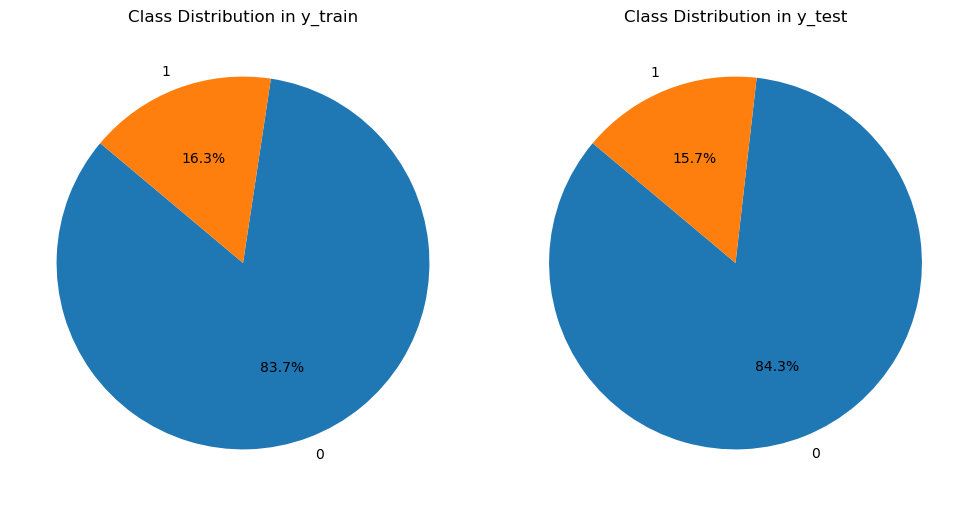

In [28]:
# Analyze distribution of the target: Attrition, on both, Test and Train Dataset

# Calculate class distribution for y_train
train_class_counts = y_train.value_counts()
train_labels = train_class_counts.index
train_sizes = train_class_counts.values

# Calculate class distribution for y_test
test_class_counts = y_test.value_counts()
test_labels = test_class_counts.index
test_sizes = test_class_counts.values

# Plot pie chart for y_train
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(train_sizes, labels=train_labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_train')

# Plot pie chart for y_test
plt.subplot(1, 2, 2)
plt.pie(test_sizes, labels=test_labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_test')

plt.tight_layout()
plt.show()

In [29]:
# Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params)  # Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1 (attrition = 1)

    # Performance evaluation
    def print_scores(alg, y_true, y_pred_proba):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        pre_score = precision_score(y_true, y_pred)
        rec_score = recall_score(y_true, y_pred)
        f_score = f1_score(y_true, y_pred, average='weighted')
        f2_score = fbeta_score(y_true, y_pred, beta=2.0)
        log_loss_score = log_loss(y_true, y_pred_proba)
        return {"Algorithm": alg_name,
                "Accuracy": acc_score,
                "Precision": pre_score,
                "Recall": rec_score,
                "F1 Score": f_score,
                "F2 Score": f2_score,
                "LogLoss": log_loss_score}

    results = print_scores(alg, y_test, y_pred_proba)
    return model, results

In [30]:
# Create an empty list for the results
results_list = []

# Apply the modeling function for each algorithm and store the results in a list
for alg, alg_name, params in zip([LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, SVC], 
                                  ["Logistic Regression", "Random Forest", "Gradient Boosting", "SVC"], 
                                  [{'max_iter':1000}, {}, {}, {'probability':True}]):
    model, results = modeling(alg, alg_name, params)
    results_list.append(results)

# Convert the results list to a pandas dataframe
model_results = pd.DataFrame(results_list)
print(model_results)

Logistic Regression
Random Forest
Gradient Boosting
SVC
             Algorithm  Accuracy  Precision    Recall  F1 Score  F2 Score  \
0  Logistic Regression  0.853488   0.655172  0.140741  0.811131  0.166960   
1        Random Forest  0.996512   1.000000  0.977778  0.996496  0.982143   
2    Gradient Boosting  0.893023   0.864407  0.377778  0.874733  0.425710   
3                  SVC  0.862791   1.000000  0.125926  0.814695  0.152603   

    LogLoss  
0  0.356174  
1  0.072481  
2  0.265187  
3  0.191279  


Based on the model evaluation metrics, here are some observations:

**Random Forest:**
- The Random Forest model has the highest accuracy (0.996512) and F1 score (0.996496), indicating excellent overall performance. 
- It also has a perfect precision score (1.0) and a very high recall score (0.977778), suggesting it can accurately identify both positive and negative cases.
- The log loss (0.072481) is the lowest among all models, which is desirable.
- Given these strong metrics, the Random Forest model seems to be the best performer.

**Gradient Boosting:**
- The Gradient Boosting model has a decent accuracy (0.893023) and F1 score (0.874733).
- However, it has a low recall score (0.377778), which means it struggles to identify positive cases (e.g., employees who will leave the company).
- The log loss (0.265187) is higher than the Random Forest model, indicating a poorer fit.
    
**Logistic Regression:**
- The Logistic Regression model has a lower accuracy (0.853488) and F1 score (0.811131) compared to the Random Forest and Gradient Boosting models.
- It has a very low recall score (0.140741), which means it fails to capture a significant number of positive cases.
- The log loss (0.356174) is the highest among all models, suggesting a poor fit.
    
**SVC (Support Vector Classifier):**
- The SVC model has a decent accuracy (0.862791) but a very low recall score (0.125926), indicating it struggles to identify positive cases.
- It has a perfect precision score (1.0), but this is likely due to the low recall, as it is predicting most instances as negative.
- The log loss (0.191279) is better than Logistic Regression but worse than Random Forest and Gradient Boosting.

Based on these results, the Random Forest model appears to be the best choice for the problem, as it outperforms the other models across multiple evaluation metrics.

Because the Random Forest model has such high accuracy and precision, it could be suspected that it may be overfitted, so some tests will be carried out to verify this.

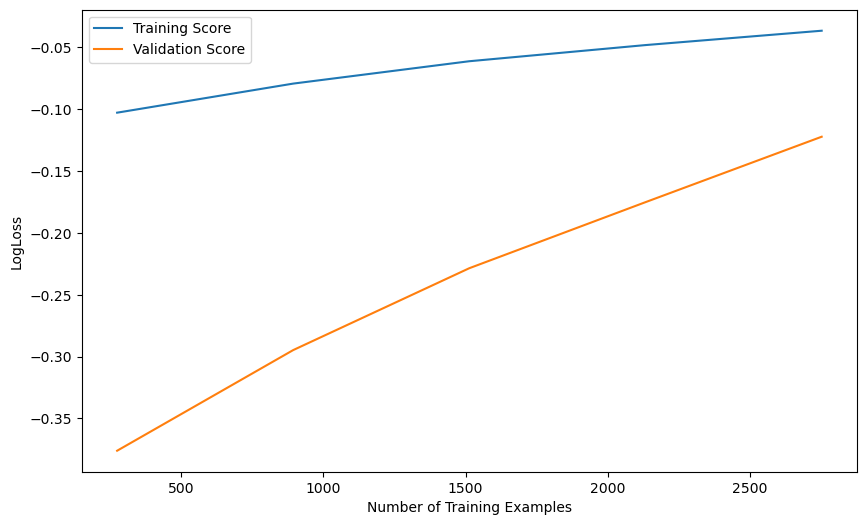

Out-of-Bag Error: 0.0090


In [31]:
# Create Random Forest model
rf = RandomForestClassifier(random_state=42, oob_score=True)

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(rf, X_train, y_train, cv=5, scoring='neg_log_loss')

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Number of Training Examples')
plt.ylabel('LogLoss')
plt.legend()
plt.show()

# Check OOB error
rf.fit(X_train, y_train)
oob_error = 1 - rf.oob_score_
print(f"Out-of-Bag Error: {oob_error:.4f}")

In [32]:
# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the scoring metrics (accuracy and log loss)
scoring = {'accuracy': make_scorer(accuracy_score),
           'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}

# Perform cross-validation with both scoring metrics
cv_scores_accuracy = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_log_loss = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_log_loss')

# Print cross-validation scores
print("Cross-validation scores (accuracy):", cv_scores_accuracy)
print("Mean cross-validation score (accuracy):", cv_scores_accuracy.mean())
print("Cross-validation scores (log loss):", cv_scores_log_loss)
print("Mean cross-validation score (log loss):", cv_scores_log_loss.mean())


Cross-validation scores (accuracy): [0.97674419 0.97965116 0.98401163 0.96947674 0.98255814]
Mean cross-validation score (accuracy): 0.9784883720930232
Cross-validation scores (log loss): [-0.12624101 -0.12248273 -0.11129375 -0.14039944 -0.11099416]
Mean cross-validation score (log loss): -0.12228221723861883


### Model Evaluation

**Out-of-Bag (OOB) Error:**
- Random Forest models provide an internal Out-of-Bag (OOB) error estimate, which can be used to evaluate the model's performance on unseen data.
- A large difference between the OOB error and the training error can indicate overfitting.

**Cross-Validation Scores:**
- If the cross-validation scores have a high variance or are significantly lower than the training score, it may indicate overfitting.
- A stable and consistent cross-validation performance is desirable.

Conclusions: it seems that the model is not overfitted because the Out-of-Bag (OOB) Error is very low (0.0090) and Cross-Validation Scores and Mean Cross-Validation Score are quite consistent.

### Hyperparameter Tuning
I consider that the model created is already good enough to seek to adjust the hyperparameters and there may be almost no difference between the models, so this will be the final version.

If it had been necessary, if I could have applied, for example, the GridSearchCV technique, defining a structure like the following:

In [33]:
'''
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required at each leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_log_loss')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
test_log_loss = best_model.score(X_test, y_test)
print("Test LogLoss of the best model:", test_log_loss)
'''
print("")

### Model Explainability

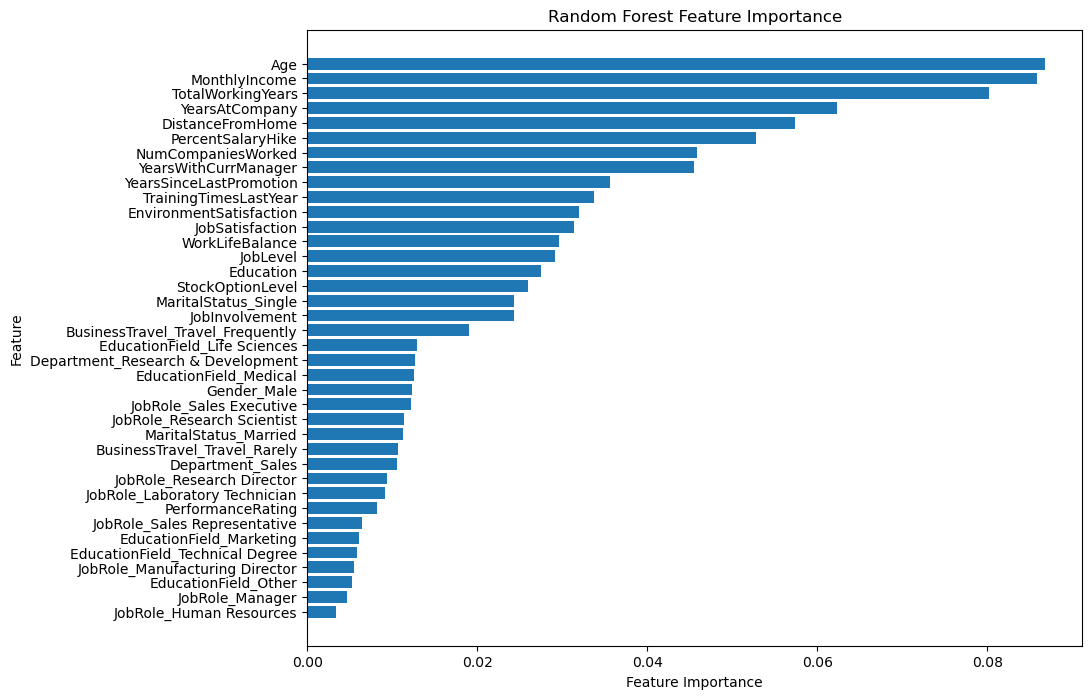

In [35]:
# Get feature importances from the trained Random Forest model
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()


In [36]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
top_n = 10
top_features = importance_df.head(top_n)
print("Top", top_n, "most important features:")
print(top_features)

Top 10 most important features:
                    Feature  Importance
0                       Age    0.086828
4             MonthlyIncome    0.085885
8         TotalWorkingYears    0.080233
10           YearsAtCompany    0.062295
1          DistanceFromHome    0.057377
6         PercentSalaryHike    0.052750
5        NumCompaniesWorked    0.045898
12     YearsWithCurrManager    0.045505
11  YearsSinceLastPromotion    0.035601
9     TrainingTimesLastYear    0.033748


Based on the top 10 most important features identified by the model, here are some suggestions based on the features to help reduce the current attrition rate in the workplace:

1. **Age**: 
    - Implement age-diverse teams: Encourage collaboration and mentorship programs between different age groups to foster a sense of inclusivity and mutual learning.

2. **MonthlyIncome**:
   - Evaluate compensation packages: Conduct a thorough review of salary and benefits packages to ensure they are competitive within the industry and aligned with employee expectations.

3. **TotalWorkingYears**:
   - Offer career development opportunities: Provide training, workshops, and mentorship programs to help employees advance in their careers within the company.

4. **YearsAtCompany**:
   - Enhance employee engagement: Implement initiatives such as recognition programs, employee feedback mechanisms, and career advancement opportunities to increase employee satisfaction and retention.

5. **DistanceFromHome**:
   - Explore flexible work arrangements: Consider offering options such as remote work, flexible hours, or transportation assistance to reduce the burden of commuting for employees.

6. **PercentSalaryHike**:
   - Conduct regular salary reviews: Ensure that salary adjustments are fair and transparent, and provide opportunities for performance-based salary increases to motivate employees.

7. **NumCompaniesWorked**:
   - Focus on employee retention: Implement strategies to build loyalty and commitment among employees, such as career development opportunities and a positive work culture.

8. **YearsWithCurrManager**:
   - Invest in leadership development: Provide training and support for managers to enhance their leadership skills, communication abilities, and employee relationship management.

9. **YearsSinceLastPromotion**:
   - Create clear career paths: Establish transparent promotion criteria and opportunities for career advancement to recognize and reward employee contributions.

10. **TrainingTimesLastYear**:
    - Prioritize employee development: Invest in ongoing training and professional development programs to enhance employee skills, knowledge, and job satisfaction.

These recommendations aim to address various factors that contribute to employee attrition and create a positive work environment conducive to employee retention. It's essential to gather feedback from employees through surveys, focus groups, or one-on-one discussions to tailor these recommendations to the specific needs and preferences of the workforce. Additionally, regularly monitor employee engagement, turnover rates, and other relevant metrics to assess the effectiveness of implemented initiatives and make adjustments as needed.

#### Additional targeting for recommendations

In [37]:
# Predict the Test set results
y_pred = rf.predict(X_test)

# Get probability score
y_pred_probs = rf.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

In [38]:
# Create the final results data set
# Add Customer ID to y_test
final_results = pd.concat([test_EmpID, y_test], axis = 1).dropna() 

#Add predictions
final_results['predictions'] = y_pred

#Add probabilities
final_results["attrition_prob(%)"] = y_pred_probs
final_results["attrition_prob(%)"] = final_results["attrition_prob(%)"]*100 
final_results["attrition_prob(%)"]=final_results["attrition_prob(%)"].round(2)
final_results = final_results[['EmployeeID', 'Attrition', 'predictions', 'attrition_prob(%)']]

# Create a ranking based on the propensity to churn %
final_results ['Ranking'] = pd.qcut(final_results['attrition_prob(%)'].rank(method = 'first'),10,labels=range(10,0,-1)) #R

# Create customer segments
bins = [0, 60, 80, 100]
labels = ['low-risk', 'medium-risk', 'high-risk']

# Final results data Set
final_results['Risk_category'] = pd.cut(final_results['attrition_prob(%)'], bins=bins, labels=labels)


In [39]:
#Show how the final results looks like
final_results

,EmployeeID,Attrition,predictions,attrition_prob(%),Ranking,Risk_category
3288,3289,0,0,1.0,9,low-risk
2894,2895,0,0,10.0,3,low-risk
2035,2036,0,0,2.0,8,low-risk
2503,2504,1,1,88.0,1,high-risk
2776,2777,0,0,2.0,8,low-risk
...,...,...,...,...,...,...
2828,2829,0,0,1.0,8,low-risk
3825,3826,0,0,6.0,4,low-risk
3738,3739,1,1,76.0,2,medium-risk
3446,3447,0,0,5.0,4,low-risk


Categories associated with the percentages were created to more easily identify those employees who are at greatest risk of leaving the company.

## Deployment

Deploying a machine learning model involves several steps, from preparing the environment to setting up the infrastructure for serving predictions. Here's a general guide on how to deploy the machine learning model for predicting employee attrition:

1. Preparing the Model:
    - Save the Model: use libraries like pickle or joblib to serialize the trained model into a file format for later use.

2.  Define the prediction function:
    - Create a function that takes an employee's data (features) as input and outputs the predicted probability and risk category (low, medium, high).
    - This function should load the saved model and use it to generate predictions.

3. Setting Up the Deployment Environment:
    - Choose a Deployment Platform: decide where you want to deploy the model. Options include cloud platforms like AWS, Azure, or Google Cloud, or deploying locally on servers.
    - Setup Environment: install necessary dependencies and libraries on the deployment environment. This includes Python, relevant libraries, and any other dependencies the model might have.

4.  Deployment:
    - This data is more like batch scoring, so we should create a script that iterates through the data and uses the prediction function.
    
5. Testing:
    - Unit Testing: Test the deployment thoroughly to ensure everything is functioning as expected. This includes both the model itself and the deployment infrastructure.
    
6.  Replication and Monitoring:
    - Ensure all dependencies (libraries, versions) are consistent between development and deployment environments.
    - Use the same pre-processing steps (data cleaning, scaling, etc) for new data as used during training.
    - Monitor the model's performance in production to identify any accuracy drifts.

## Takeaways

- Because the model gave good results, I didn't do the exercise to see what happened if I balanced the data, so it is an exercise that could also be done.
- It would be necessary to see if studying the entrances and exits of employees is also an important characteristic to predict attrition.

## Recomendations to improve the efficiency of the data collection

With respect to surveys, some details must be evaluated, for example:
- How many surveys are applied per year? This is important to review, because if only 1 is applied, it could have a certain bias due to the moment in which it was applied, for example, if an employee was promoted, it is likely that he would answer everything very positively, while if it was after receiving a bonus and the person did not receive the expected amount, the responses may not be as positive. For that reason, it would be good to apply several surveys in a year and then evaluate the results during the period and not at a specific time.
- You could also analyze whether the percentage of salary increase from one year to the next influences something, perhaps those who do not have their salaries increased so much tend not to feel as comfortable.
- It would be good to analyze/ask in some way if the person feels that he is really doing tasks for which he was hired and not that he is doing others that are not so attractive.
- In general terms, more exhaustive surveys could be carried out, trying to identify other reasons that may motivate an employee to leave the company.